In [1]:
import pyfolio as pf
import json
%matplotlib inline
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/haard/.conda/envs/rl_project2/lib/python2.7/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [2]:
# config=json.loads(open('./config/quandl_config.json','r').read())
API_KEY='YymazpXMih5PZSD8VWyn'

In [46]:
# -*- coding:utf-8 -*-
import quandl
import pandas as pd
import talib
import numpy as np
import os


class StockEnv(object):
    def __init__(self, instruments,
                 api_key,
                 capital_base=1e5,
                 start_date='2002-01-01',
                 end_date=None,
                 data_local_path='./data',
                 re_download=False,
                 commission_fee=5e-3,
                 normalize_length=10
                 ):
        self.api_key = api_key
        quandl.ApiConfig.api_key = self.api_key
        self.instruments = instruments
        self.capital_base = capital_base
        self.commission_fee = commission_fee
        self.normalize_length = normalize_length
        self.start_date = start_date
        self.end_date = end_date
        self.data_local_path = data_local_path
        self.preprocessed_market_data, self.cleaned_market_data = self._init_market_data(re_download=re_download)
        self.pointer = normalize_length - 1
        self.done = (self.pointer == (self.preprocessed_market_data.shape[1] - 1))

        self.current_position = np.zeros(len(self.instruments))
        self.current_portfolio_value = np.concatenate((np.zeros(len(self.instruments)), [self.capital_base]))
        self.current_weight = np.concatenate((np.zeros(len(self.instruments)), [1.]))
        self.current_date = self.preprocessed_market_data.major_axis[self.pointer]

        self.portfolio_values = []
        self.positions = []
        self.weights = []
        self.trade_dates = []

    def reset(self):
        self.pointer = self.normalize_length
        self.current_position = np.zeros(len(self.instruments))
        self.current_portfolio_value = np.concatenate((np.zeros(len(self.instruments)), [self.capital_base]))
        self.current_weight = np.concatenate((np.zeros(len(self.instruments)), [1.]))
        self.current_date = self.preprocessed_market_data.major_axis[self.pointer]
        self.done = (self.pointer == (self.preprocessed_market_data.shape[1] - 1))

        self.portfolio_values = []
        self.positions = []
        self.weights = []
        self.trade_dates = []

        return self._get_normalized_state(), self.done

    def step(self, action):
        assert action.shape[0] == len(self.instruments) + 1
        assert np.sum(action) <= 1 + 1e5
        current_price = self.cleaned_market_data[:, :, 'adj_close'].iloc[self.pointer].values
        self._rebalance(action=action, current_price=current_price)

        self.pointer += 1
        self.done = (self.pointer == (self.preprocessed_market_data.shape[1] - 1))
        next_price = self.cleaned_market_data[:, :, 'adj_close'].iloc[self.pointer].values
        reward = self._get_reward(current_price=current_price, next_price=next_price)
        state = self._get_normalized_state()
        return state, reward, self.done

    def _rebalance(self, action, current_price):
        target_weight = action
        target_value = np.sum(self.current_portfolio_value) * target_weight
        target_position = target_value[:-1] / current_price
        trade_amount = target_position - self.current_position
        commission_cost = np.sum(self.commission_fee * np.abs(trade_amount) * current_price)

        self.current_position = target_position
        self.current_portfolio_value = target_value - commission_cost
        self.current_weight = target_weight
        self.current_date = self.preprocessed_market_data.major_axis[self.pointer]

        self.positions.append(self.current_position.copy())
        self.weights.append(self.current_weight.copy())
        self.portfolio_values.append(self.current_portfolio_value.copy())
        self.trade_dates.append(self.current_date)

    def _get_normalized_state(self):
        data = self.preprocessed_market_data.iloc[:, self.pointer + 1 - self.normalize_length:self.pointer + 1, :].values
        state = ((data - np.mean(data, axis=1, keepdims=True)) / (np.std(data, axis=1, keepdims=True) + 1e-5))[:, -1, :]
        return np.concatenate((state, self.current_weight[:-1][:, None]), axis=1)

    def get_meta_state(self):
        return self.preprocessed_market_data.iloc[:, self.pointer, :]

    def _get_reward(self, current_price, next_price):
        return_rate = (next_price / current_price)
        log_return = np.log(return_rate)
        last_weight = self.current_weight.copy()
        securities_value = self.current_portfolio_value[:-1] * return_rate
        self.current_portfolio_value[:-1] = securities_value
        self.current_weight = self.current_portfolio_value / np.sum(self.current_portfolio_value)
        reward = last_weight[:-1] * log_return
        return reward

    def _init_market_data(self, data_name='market_data.pkl', pre_process=True, re_download=False):
        data_path = self.data_local_path + '/' + data_name
        if not os.path.exists(data_path) or re_download:
            print('Start to download market data')
            stocks = quandl.get_table('WIKI/PRICES', ticker=self.instruments,
                                      qopts={'columns': ['ticker', 'date', 'adj_open', 'adj_close', 'adj_high', 'adj_low', 'adj_volume']},
                                      date={'gte': self.start_date, 'lte': self.end_date}, paginate=True)
            stock_groups = stocks.groupby('ticker')
            stocks = {}
            for k in stock_groups.groups.keys():
                group = stock_groups.get_group(k)
                group.index = group.date
                stocks[k] = group[['adj_open', 'adj_close', 'adj_high', 'adj_low', 'adj_volume']]
            market_data = pd.DataFrame(stocks).fillna(method='ffill').fillna(method='bfill')
            market_data.to_pickle(data_path)
            print('Done')
        else:
            print('market data exist, loading')
            market_data = pd.read_pickle(data_path).fillna(method='ffill').fillna(method='bfill')
        if pre_process:
            processed_market_data, cleaned_market_data = StockEnv._pre_process(market_data, open_c='adj_open', close_c='adj_close', high_c='adj_high', low_c='adj_low', volume_c='adj_volume')
        assert np.sum(np.isnan(processed_market_data.values)) == 0
        assert np.sum(np.isnan(cleaned_market_data.values)) == 0
        return processed_market_data, cleaned_market_data

    def get_summary(self):
        portfolio_value_df = pd.DataFrame(np.array(self.portfolio_values), index=np.array(self.trade_dates), columns=self.instruments + ['cash'])
        positions_df = pd.DataFrame(np.array(self.positions), index=np.array(self.trade_dates), columns=self.instruments)
        weights_df = pd.DataFrame(np.array(self.weights), index=np.array(self.trade_dates), columns=self.instruments + ['cash'])
        return portfolio_value_df, positions_df, weights_df

    @staticmethod
    def _pre_process(market_data, open_c, high_c, low_c, close_c, volume_c):
        preprocessed_data = {}
        cleaned_data = {}
        for c in market_data.items:
            columns = [open_c, close_c, high_c, low_c, volume_c]
            security = market_data[c, :, columns].fillna(method='ffill').fillna(method='bfill')
            security[volume_c] = security[volume_c].replace(0, np.nan).fillna(method='ffill')
            cleaned_data[c] = security.copy()
            tech_data = StockEnv._get_indicators(security=security.astype(float), open_name=open_c, close_name=close_c, high_name=high_c, low_name=low_c, volume_name=volume_c)
            preprocessed_data[c] = tech_data
        preprocessed_data = pd.Panel(preprocessed_data).dropna()
        cleaned_data = pd.Panel(cleaned_data)[:, preprocessed_data.major_axis, :].dropna()
        return preprocessed_data, cleaned_data

    @staticmethod
    def _get_indicators(security, open_name, close_name, high_name, low_name, volume_name):
        open_price = security[open_name].values
        close_price = security[close_name].values
        low_price = security[low_name].values
        high_price = security[high_name].values
        volume = security[volume_name].values if volume_name else None
        security['MOM'] = talib.MOM(close_price)
        security['HT_DCPERIOD'] = talib.HT_DCPERIOD(close_price)
        security['HT_DCPHASE'] = talib.HT_DCPHASE(close_price)
        security['SINE'], security['LEADSINE'] = talib.HT_SINE(close_price)
        security['INPHASE'], security['QUADRATURE'] = talib.HT_PHASOR(close_price)
        security['ADXR'] = talib.ADXR(high_price, low_price, close_price)
        security['APO'] = talib.APO(close_price)
        security['AROON_UP'], _ = talib.AROON(high_price, low_price)
        security['CCI'] = talib.CCI(high_price, low_price, close_price)
        security['PLUS_DI'] = talib.PLUS_DI(high_price, low_price, close_price)
        security['PPO'] = talib.PPO(close_price)
        security['MACD'], security['MACD_SIG'], security['MACD_HIST'] = talib.MACD(close_price)
        security['CMO'] = talib.CMO(close_price)
        security['ROCP'] = talib.ROCP(close_price)
        security['FASTK'], security['FASTD'] = talib.STOCHF(high_price, low_price, close_price)
        security['TRIX'] = talib.TRIX(close_price)
        security['ULTOSC'] = talib.ULTOSC(high_price, low_price, close_price)
        security['WILLR'] = talib.WILLR(high_price, low_price, close_price)
        security['NATR'] = talib.NATR(high_price, low_price, close_price)
        security['RSI'] = talib.RSI(close_price)
        security['EMA'] = talib.EMA(close_price)
        security['SAREXT'] = talib.SAREXT(high_price, low_price)
        # security['TEMA'] = talib.EMA(close_price)
        security['RR'] = security[close_name] / security[close_name].shift(1).fillna(1)
        security['LOG_RR'] = np.log(security['RR'])
        if volume_name:
            security['MFI'] = talib.MFI(high_price, low_price, close_price, volume)
            # security['AD'] = talib.AD(high_price, low_price, close_price, volume)
            # security['OBV'] = talib.OBV(close_price, volume)
            security[volume_name] = np.log(security[volume_name])
        security.drop([open_name, close_name, high_name, low_name], axis=1)
        security = security.dropna().astype(np.float32)
        return security


In [4]:
# -*- coding:utf-8 -*-
from abc import abstractmethod


class Agent(object):
    def __init__(self):
        pass
    
    @abstractmethod
    def trade(self, state):
        pass
    
    def train(self):
        pass
    
    @abstractmethod
    def load_model(self, model_path):
        pass
    
    @abstractmethod
    def save_model(self, model_path):
        pass

In [51]:
# -*- coding:utf-8 -*-
from agents.agent import Agent
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os


class Actor(nn.Module):
    def __init__(self, s_dim, b_dim, rnn_layers=1, dp=0.2):
        super(Actor, self).__init__()
        self.s_dim = s_dim
        self.b_dim = b_dim
        self.rnn_layers = rnn_layers
        self.gru = nn.GRU(self.s_dim, 128, self.rnn_layers, batch_first=True)
        self.fc_policy_1 = nn.Linear(128, 128)
        self.fc_policy_2 = nn.Linear(128, 64)
        self.fc_policy_out = nn.Linear(64, 1)
        self.fc_cash_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=dp)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.initial_hidden = torch.zeros(self.rnn_layers, self.b_dim, 128, dtype=torch.float32)

    def forward(self, state, hidden=None, train=False):
        state, h = self.gru(state, hidden)
        if train:
            state = self.dropout(state)
        state = self.relu(self.fc_policy_1(state))
        state = self.relu(self.fc_policy_2(state))
        cash = self.sigmoid(self.fc_cash_out(state))
        action = self.sigmoid(self.fc_policy_out(state)).squeeze(-1).t()
        cash = cash.mean(dim=0)
        action = torch.cat(((1 - cash) * action, cash), dim=-1)
        action = action / (action.sum(dim=-1, keepdim=True) + 1e-10)
        return action, h.data


class DRLAgent(Agent):
    def __init__(self, s_dim, b_dim, batch_length=64, learning_rate=1e-3, rnn_layers=1):
        super(Agent, self).__init__()
        self.s_dim = s_dim
        self.b_dim = b_dim
        self.batch_length = batch_length
        self.pointer = 0
        self.s_buffer = []
        self.d_buffer = []

        self.train_hidden = None
        self.trade_hidden = None
        self.actor = Actor(s_dim=self.s_dim, b_dim=self.b_dim, rnn_layers=rnn_layers)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)

    def _trade(self, state, train=False):
        with torch.no_grad():
            a, self.trade_hidden = self.actor(state[:, None, :], self.trade_hidden, train=False)
        return a

    def trade(self, state, train=False):
        state_ = torch.tensor(state, dtype=torch.float32)
        action = self._trade(state_, train=train)
        return action.numpy().flatten()

    def train(self):
        self.optimizer.zero_grad()
#         print torch.stack(self.s_buffer) 
#         s = torch.stack(self.s_buffer)
        s = torch.stack(self.s_buffer, dim=1)
        d = torch.stack(self.d_buffer)
        a_hat, self.train_hidden = self.actor(s, self.train_hidden, train=True)
        reward = -(a_hat[:, :-1] * d).mean()
        reward.backward()
        for param in self.actor.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def reset_model(self):
        self.s_buffer = []
        self.d_buffer = []
        self.trade_hidden = None
        self.train_hidden = None
        self.pointer = 0

    def save_transition(self, state, diff):
        if self.pointer < self.batch_length:
#             print state
            self.s_buffer.append(torch.tensor(state, dtype=torch.float32))
            self.d_buffer.append(torch.tensor(diff, dtype=torch.float32))
            self.pointer += 1
        else:
            self.s_buffer.pop(0)
            self.d_buffer.pop(0)
            self.s_buffer.append(torch.tensor(state, dtype=torch.float32))
            self.d_buffer.append(torch.tensor(diff, dtype=torch.float32))

    def load_model(self, model_path='./DRL_Torch'):
        self.actor = torch.load(model_path + '/model.pkl')

    def save_model(self, model_path='./DRL_Torch'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        torch.save(self.actor, model_path + '/model.pkl')


In [47]:
env=StockEnv(api_key=API_KEY,instruments=['IBM','GE','BA','MMM','ABT','CA'],start_date='2005-01-01',re_download=False,commission_fee=0)

market data exist, loading


/home/haard/.conda/envs/rl_project2/lib/python2.7/site-packages/ipykernel_launcher.py:126: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



In [48]:
b_dim=env.preprocessed_market_data.shape[0]
s_dim=env.preprocessed_market_data.shape[-1]+1

print b_dim
print s_dim

6
36


In [52]:
agent=DRLAgent(b_dim=b_dim,s_dim=s_dim,batch_length=64)

/home/haard/.conda/envs/rl_project2/lib/python2.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


240654.83
290456.8
363831.72
449514.88
702520.56



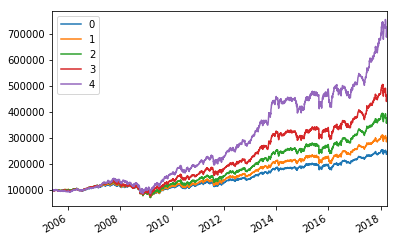

In [53]:
for e in tqdm_notebook(range(10)):
    state,done=env.reset()
    agent.reset_model()
    while not done:
        action=agent.trade(state,train=True)
        next_state,reward,done=env.step(action=action)
        next_log_rr=env.get_meta_state().loc['LOG_RR'].values
        agent.save_transition(state=state,diff=next_log_rr)
        state=next_state
        if env.pointer % 64==0:
            agent.train()
    pv,pp,pw=env.get_summary()
    print(pv.iloc[-1].sum())
    total_pv=pv.sum(axis=1)
    total_pv.name=str(e)
    total_pv.plot(legend=True)
    if pv.iloc[-1].sum()> 500000: break
    

In [71]:
env.preprocessed_market_data

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 3242 (major_axis) x 35 (minor_axis)
Items axis: ABT to MMM
Major_axis axis: 2005-05-10 00:00:00 to 2018-03-27 00:00:00
Minor_axis axis: adj_open to MFI

In [54]:
pv,pp,pw=env.get_summary()

Text(0.5,1,'strategy')

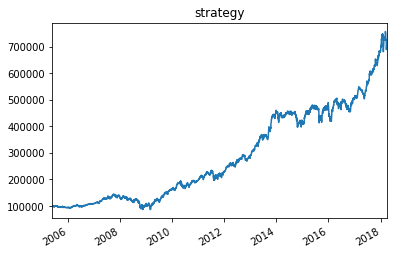

In [55]:
pv.sum(axis=1).plot()
plt.title('strategy')

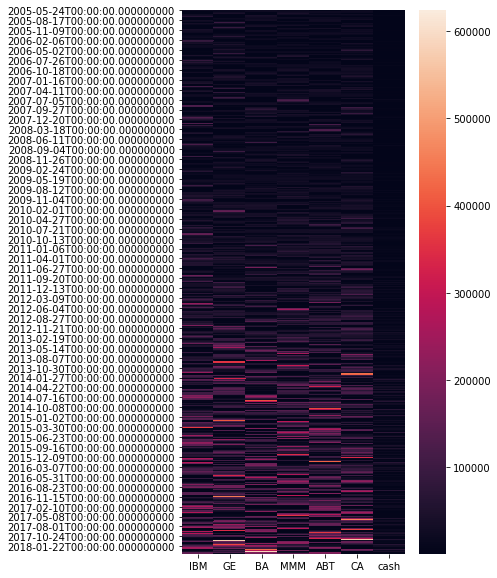

In [56]:
plt.figure(figsize=(5,10))
sns.heatmap(pv)

In [57]:
_,done=env.reset()
weight=np.concatenate((np.ones(len(env.instruments))/len(env.instruments),[0]))
while not done:
    _,_,done=env.step(action=weight)
    weight=env.current_weight

In [58]:
bpv,bpp,bpw=env.get_summary()

Text(0.5,1,'buy and hold')

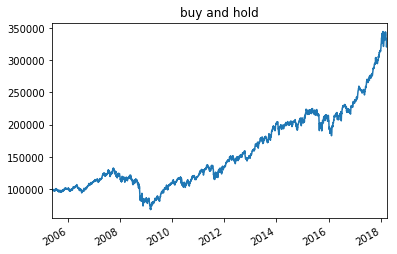

In [63]:
bpv.sum(axis=1).plot()
plt.title('buy and hold')

In [64]:
pr=pv.sum(axis=1).pct_change()
bpr=bpv.sum(axis=1).pct_change()

Start date,2005-05-24
End date,2018-03-26
Total months,153
,Backtest
Annual return,16.4%
Cumulative returns,602.5%
Annual volatility,18.9%
Sharpe ratio,0.90
Calmar ratio,0.41
Stability,0.96
Max drawdown,-40.3%


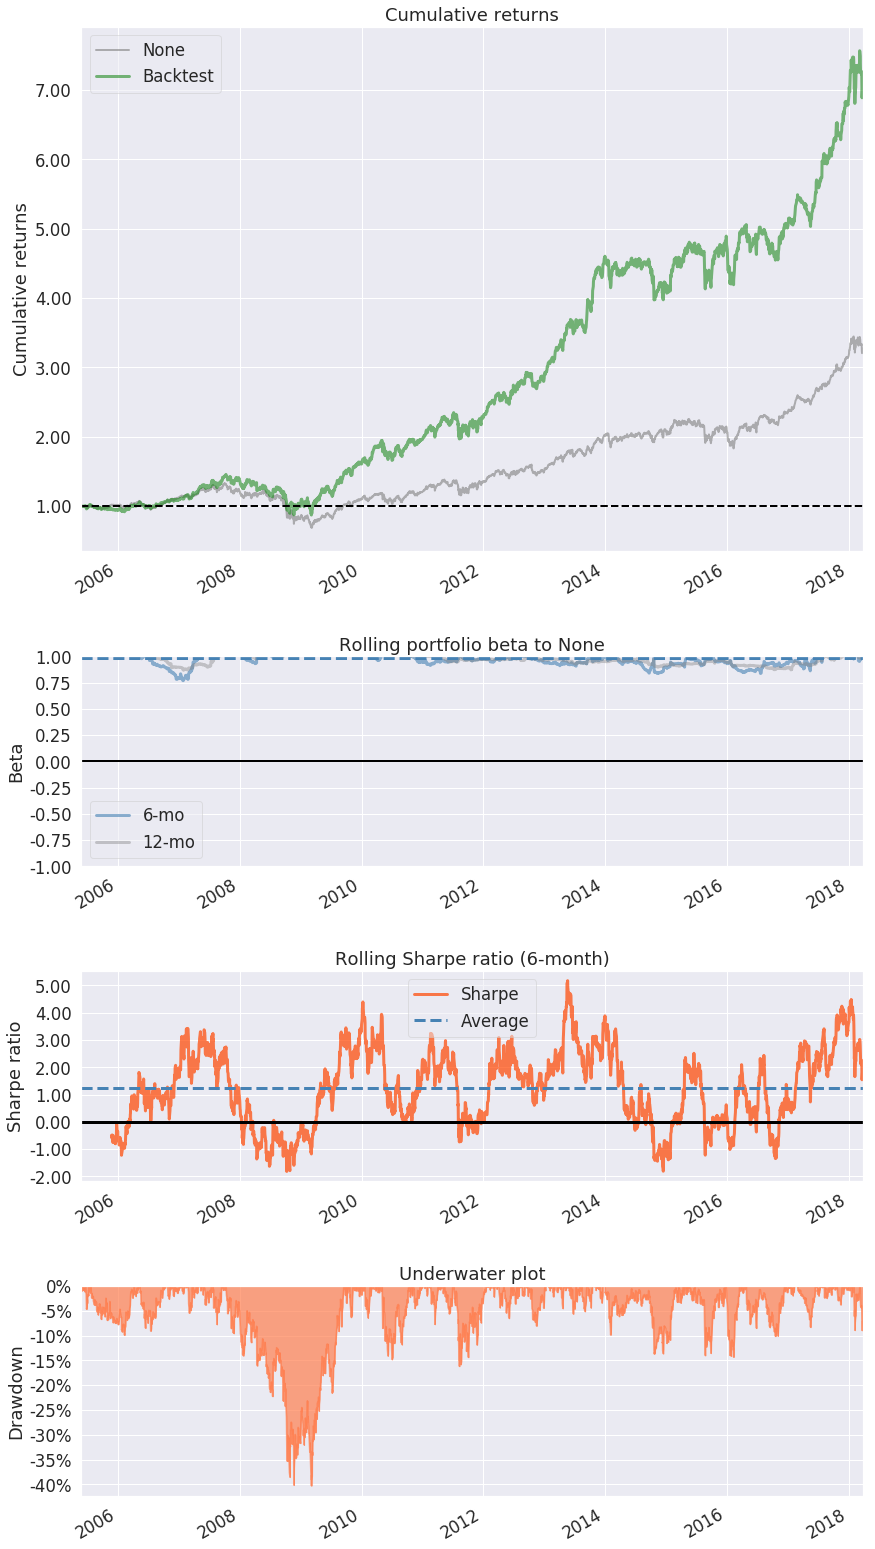

In [65]:
pf.create_simple_tear_sheet(returns=pr,benchmark_rets=bpr)

Top 10 long positions of all time,max
ABT,100.00%
IBM,100.00%
GE,99.99%
CA,99.98%
BA,99.95%
MMM,99.93%


Top 10 short positions of all time,max


Top 10 positions of all time,max
ABT,100.00%
IBM,100.00%
GE,99.99%
CA,99.98%
BA,99.95%
MMM,99.93%


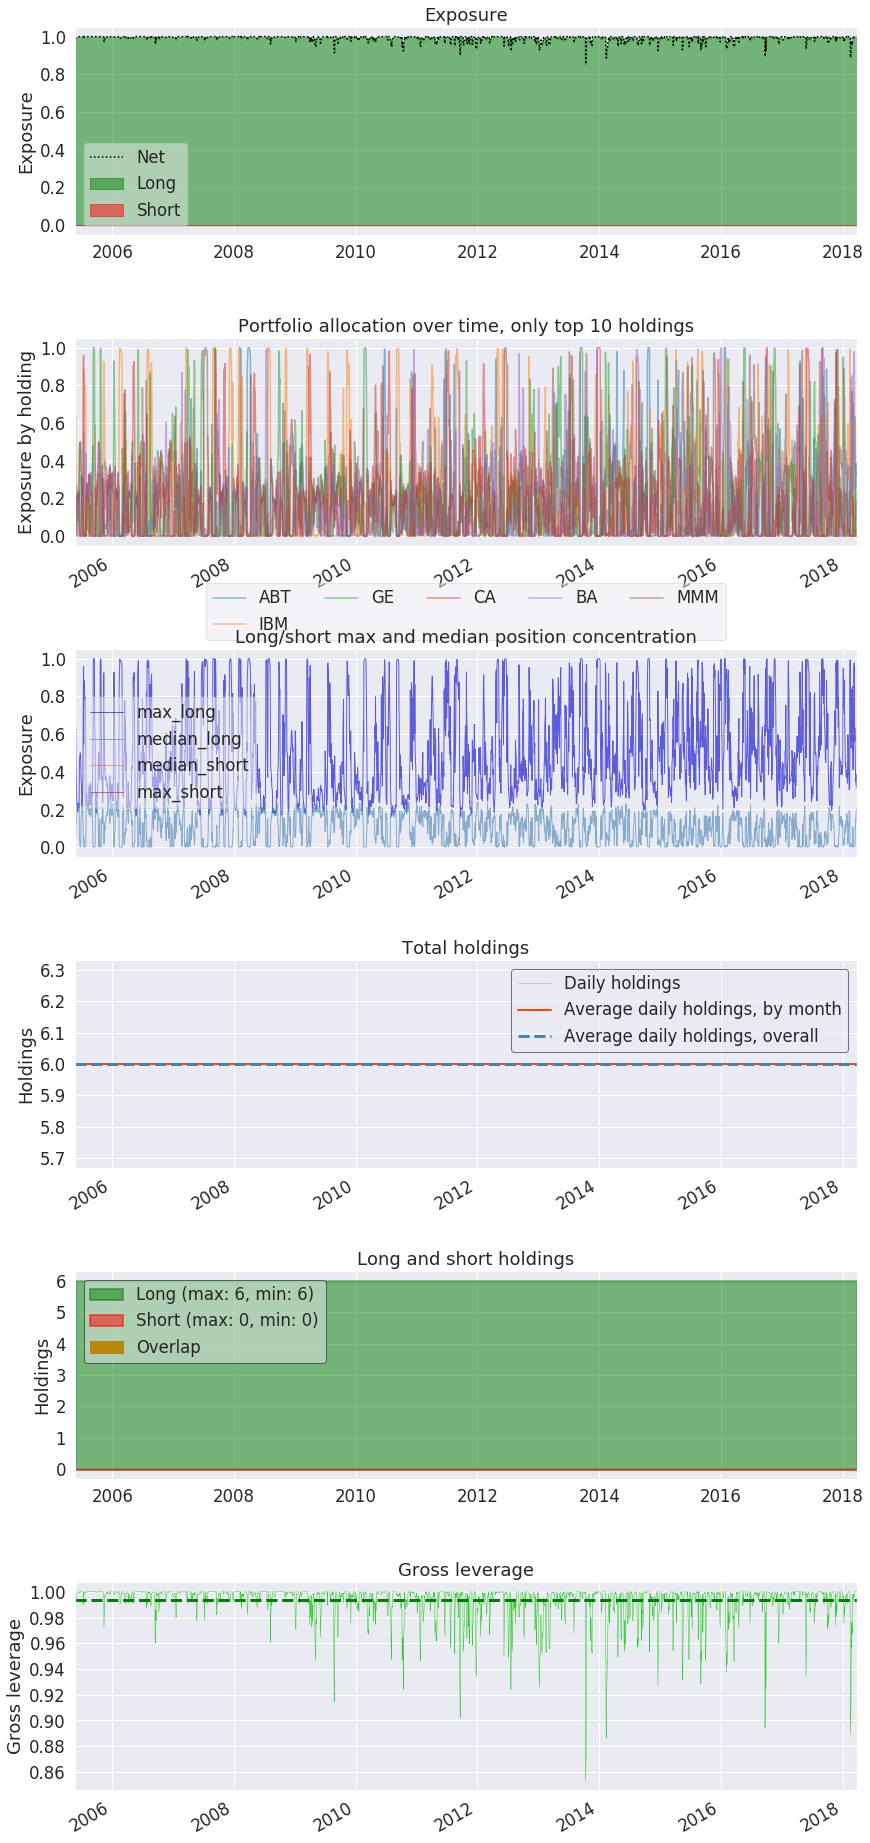

In [66]:
pf.create_position_tear_sheet(pr,pw*pv)

Stress Events,mean,min,max
Lehman,-0.11%,-5.81%,4.80%
US downgrade/European Debt Crisis,0.08%,-5.18%,3.78%
Fukushima,0.29%,-2.54%,1.84%
EZB IR Event,0.01%,-0.93%,1.25%
Aug07,0.06%,-3.15%,2.42%
Mar08,-0.06%,-2.44%,2.35%
Sept08,-0.30%,-5.81%,4.80%
2009Q1,-0.21%,-5.56%,5.35%
2009Q2,0.48%,-4.17%,7.91%
Flash Crash,-0.58%,-3.16%,4.08%


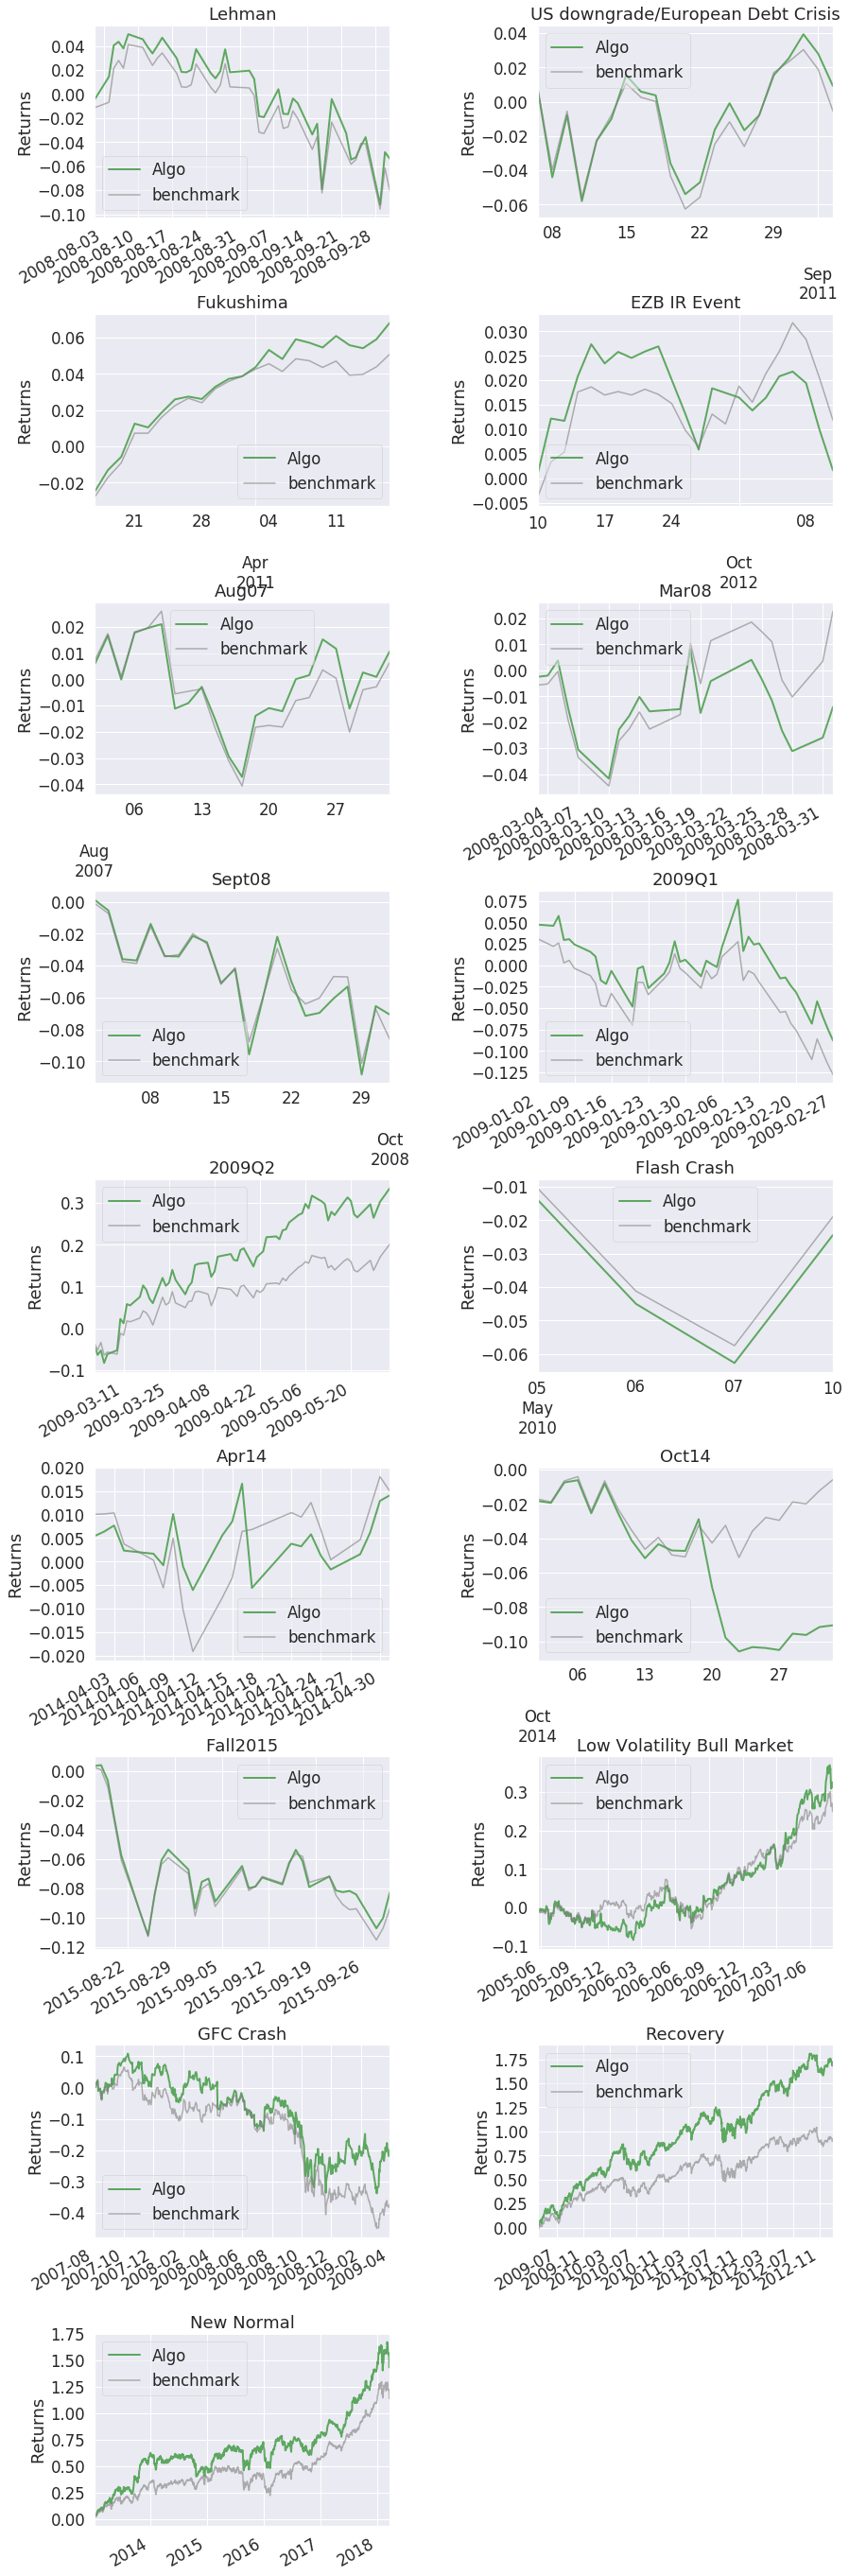

In [68]:
pf.create_interesting_times_tear_sheet(returns=pr,benchmark_rets=bpr)